### What is the loss in accuracy upon trucation of the Pauli Weight and/or Frequencies?

In [10]:
import pennylane as qml
import pennylane.numpy as np
from pprop.propagator import Propagator
import matplotlib.pyplot as plt

In [39]:
# Define a circuit that we can exactly compute the output

num_qubits = 12
def ansatz(params):
    for q in range(num_qubits):
        qml.Hadamard(wires=q)
        qml.RY(params[q], wires=q)
        
    for q_control, q_target in zip(range(0, num_qubits, 2), range(1, num_qubits, 2)):
        qml.CNOT(wires=[q_control, q_target])

    qml.Barrier()

    for q in range(num_qubits):
        qml.RY(params[num_qubits+q], wires=q)

    for q_control, q_target in zip(range(1, num_qubits, 2), range(2, num_qubits, 2)):
        qml.CNOT(wires=[q_control, q_target])

    qml.Barrier()

    for q in range(num_qubits):
        qml.RY(params[2*num_qubits+q], wires=q)


    return [qml.expval(qml.PauliZ(qubit)) for qubit in range(num_qubits)]

In [40]:
def mse_std(X, Y):
    """Calculate the Mean Squared Error (MSE) loss."""
    diffs = (X - Y) ** 2
    return np.mean(diffs), np.std(diffs)

def evaluate_accuracy(ansatz, cutoffs, num_outputs = 100):
    device = qml.device('default.qubit', wires=num_qubits)
    circuit = qml.QNode(ansatz, device)

    temp_prop = Propagator(ansatz) 
    params_list = 2*np.pi*np.random.rand(num_outputs, temp_prop.num_params)
    del temp_prop
    
    print('Computing exact outputs...')
    targets = np.array([circuit(params) for params in params_list])
    
    print('Propagating...')
    pprop_dict = {}
    for k1, k2 in cutoffs:
        prop =  Propagator(ansatz, k1=k1, k2=k2)
        prop.propagate(bar = False)
        
        pprop_dict[(k1, k2)] = prop.lambdify()
        
    print('Estimating accuracies...')
    mse_dict = {}
    std_dict = {}
    for k1, k2 in cutoffs:
        mse_dict[(k1, k2)], std_dict[(k1, k2)] = mse_std(np.array([pprop_dict[(k1, k2)](params) for params in params_list]), targets)
        
    print('Done!')
    return mse_dict, std_dict


In [41]:
# Study on Pauli Weights
cutoffs1 = [(i1, None) for i1 in range(1, 6)]
mse_dict1, std_dict1 = evaluate_accuracy(ansatz, cutoffs1, num_outputs = 100)

Computing exact outputs...
Propagating...
Estimating accuracies...
Done!


In [42]:
# Study on Frequencies
cutoffs2 = [(None, i2) for i2 in range(1, 10)]
mse_dict2, std_dict2 = evaluate_accuracy(ansatz, cutoffs2, num_outputs = 10)

Computing exact outputs...
Propagating...
Estimating accuracies...
Done!


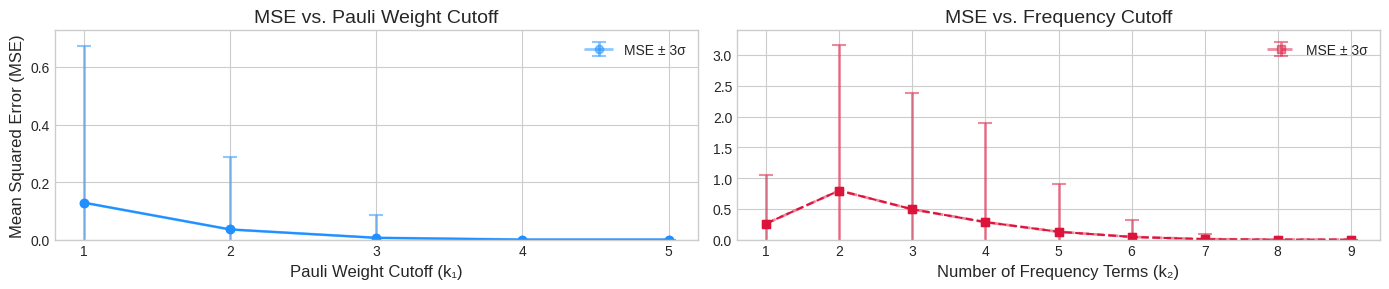

In [46]:
# Extract data for the first plot (Pauli Weight Cutoff)
x1 = [key[0] for key in mse_dict1.keys()]
y1 = [mse_dict1[key] for key in mse_dict1.keys()]
yerr1 = [3 * std_dict1[key] for key in mse_dict1.keys()]

# Extract data for the second plot (Frequencies)
x2 = [key[1] for key in mse_dict2.keys()]
y2 = [mse_dict2[key] for key in mse_dict2.keys()]
yerr2 = [3 * std_dict2[key] for key in mse_dict2.keys()]

plt.style.use('seaborn-v0_8-whitegrid')  # Optional styling

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 3), sharey=False)

# --- First subplot ---
ax1.errorbar(x1, y1, yerr=yerr1, fmt='o-', capsize=5, capthick=1.5, lw=2,
             label='MSE ± 3σ', alpha=0.5, color='dodgerblue')
ax1.plot(x1, y1, 'o-', color='dodgerblue')
ax1.set_xticks(sorted(set(x1)))
ax1.set_xlabel('Pauli Weight Cutoff (k₁)', fontsize=12)
ax1.set_ylabel('Mean Squared Error (MSE)', fontsize=12)
ax1.set_title('MSE vs. Pauli Weight Cutoff', fontsize=14)
ax1.set_ylim((0, None))
ax1.legend()
ax1.grid(True)

# --- Second subplot ---
ax2.errorbar(x2, y2, yerr=yerr2, fmt='s--', capsize=5, capthick=1.5, lw=2,
             label='MSE ± 3σ', alpha=0.5, color='crimson')
ax2.plot(x2, y2, 's--', color='crimson')
ax2.set_xticks(sorted(set(x2)))
ax2.set_xlabel('Number of Frequency Terms (k₂)', fontsize=12)
ax2.set_title('MSE vs. Frequency Cutoff', fontsize=14)
ax2.set_ylim((0, None))
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
